# School preprocessing

This notebook aggregates the School data such that the relevant fields are extracted and the data is neatly formatted into a csv wherein the rows are associated with an SA2

In [112]:
import pandas as pd
import geopandas as gpd
from shapely import Point

In [113]:
df = pd.read_csv("../../data/landing/school_data.csv")

def convert_price(price):
    if pd.isna(price):
        return 0  # Replace NaN with 0
    if '-' in price:
        # If the price is a range, split it and take the average
        price_range = price.replace('$', '').split(' - ')
        return sum([float(p) for p in price_range]) / len(price_range)
    else:
        # If it's a single price, just remove the $ and convert to float
        return float(price.replace('$', ''))

# Apply the price conversion function directly on the original DataFrame 'df' before converting it to a GeoDataFrame
df['average_price'] = df['price_local'].apply(convert_price)

filtered_df = df[df['median_score'].notna()]
filtered_df.head()

,school_name,school_type,median_score,price_local,ELC,Kinder,Primary,Secondary,href,latitude,longitude,average_price
1695,Lynall Hall Community School,government,20.80,NaN,False,True,True,True,https://www.aroundschools.com.au/schools/detai...,-37.816173,145.001977,0.0
1696,Ozford College,independent,21.18,$20000,False,True,True,True,https://www.aroundschools.com.au/schools/detai...,-37.810607,144.968516,20000.0
1697,Laverton College P-12,government,21.82,NaN,False,True,True,True,https://www.aroundschools.com.au/schools/detai...,-37.857123,144.772763,0.0
1698,Hallam Secondary College,government,22.55,$12210 - $13640,False,True,True,True,https://www.aroundschools.com.au/schools/detai...,-38.000470,145.264404,12925.0
1699,Northern Bay P-12 College,government,22.55,NaN,False,True,True,True,https://www.aroundschools.com.au/schools/detai...,-38.077244,144.348383,0.0


In [114]:
# Create geometry from the latitude and longitude
df['geometry'] = filtered_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

# Convert to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

In [115]:
SA2 = gpd.read_file("../../data/landing/SAL_data/")

In [116]:
SA2.shape

(15353, 11)

In [117]:
schools_in_sa2 = gpd.sjoin(SA2, gdf , how="inner", predicate="intersects")

/var/folders/vs/mmhmvz2124bdlbwz4b6zdqqh0000gn/T/ipykernel_20349/217267687.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:7844
Right CRS: None

  schools_in_sa2 = gpd.sjoin(SA2, gdf , how="inner", predicate="intersects")


In [118]:
# Group by SA2_CODE21 and calculate the mean score and mean price
grouped_df = schools_in_sa2.groupby('SAL_CODE21').agg({
    'median_score': 'mean',
    'average_price': 'mean'
}).reset_index()

# Display the grouped data
grouped_df.shape

(350, 3)

In [119]:
import matplotlib.pyplot as plt

In [120]:
# merge with SAL data
grouped_df = SA2.merge(grouped_df, left_on='SAL_CODE21', right_on='SAL_CODE21', how='left')

# BEGIN: Impute missing values with average
grouped_df['median_score'].fillna(grouped_df['median_score'].mean(), inplace=True)
grouped_df['average_price'].fillna(grouped_df['average_price'].mean(), inplace=True)
# END:

#remove no geometry
grouped_df = grouped_df[grouped_df['geometry'].notna()]


In [ ]:
to_csv = grouped_df[['SAL_CODE21', 'median_score', 'average_price']]

# change SAL_CODE21 to SAL_CODE
to_csv.rename(columns={'SAL_CODE21': 'SAL_CODE'}, inplace=True)

to_csv.shape

In [ ]:
to_csv.to_csv('../../data/curated/schools_by_SAL.csv', index=False)

In [121]:
grouped_df.shape

(15334, 13)

In [122]:
from math import radians, cos, sin, asin, sqrt

# for better visualisaiton, remove suburbs too far outside melbourne
# Compute distance to Melbourne CBD
melbourne_cbd_coords = (-37.8136, 144.9631)  # Latitude and Longitude of Melbourne CBD

# Function to calculate distance
def haversine(lat1, lon1, lat2, lon2):
    # convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    # haversine formula
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371  # Radius of earth in kilometers
    return c * r

# Apply the function to calculate distance to Melbourne CBD
grouped_df['distance_to_CBD'] = grouped_df.apply(lambda row: haversine(row['geometry'].centroid.y, row['geometry'].centroid.x, melbourne_cbd_coords[0], melbourne_cbd_coords[1]), axis=1)

# Filter out suburbs too far outside Melbourne (e.g., more than 50 km)
grouped_df = grouped_df[grouped_df['distance_to_CBD'] <= 50]


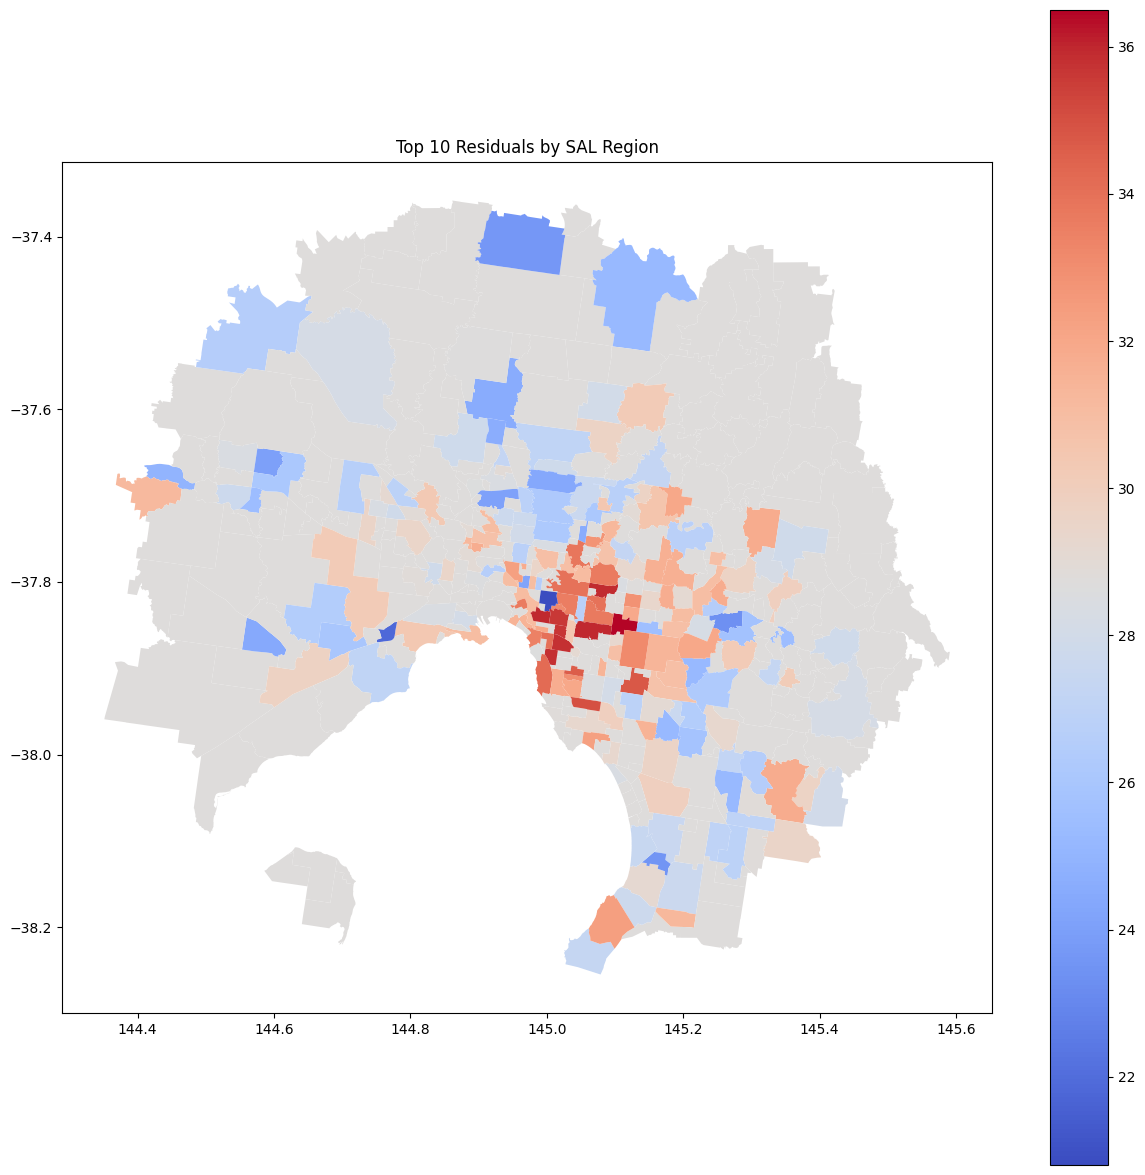

In [123]:


# graph top 10 residuals
fig, ax = plt.subplots(figsize=(15, 15))
grouped_df.plot(column='median_score', ax=ax, legend=True, cmap='coolwarm')
plt.title('Top 10 Residuals by SAL Region')
plt.show()

/var/folders/vs/mmhmvz2124bdlbwz4b6zdqqh0000gn/T/ipykernel_20349/1345427653.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_csv.rename(columns={'SAL_CODE21': 'SAL_CODE'}, inplace=True)


(463, 3)

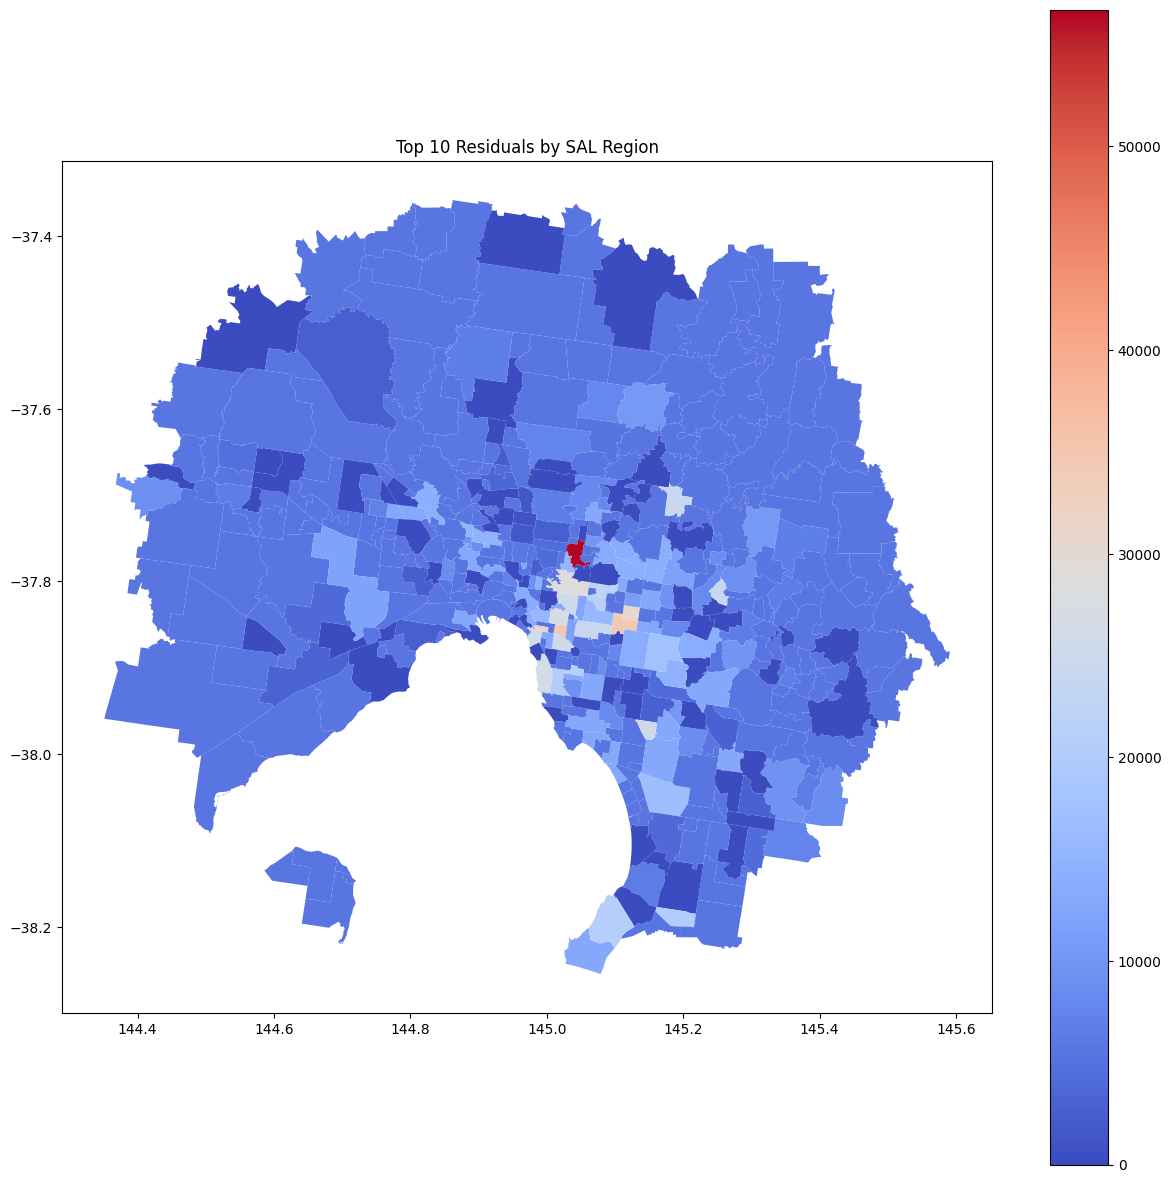

In [126]:
# graph top 10 residuals
fig, ax = plt.subplots(figsize=(15, 15))
grouped_df.plot(column='average_price', ax=ax, legend=True, cmap='coolwarm')
plt.title('Top 10 Residuals by SAL Region')
plt.show()

In [127]:
grouped_df.to_csv("../../data/curated/schools.csv", index=False)